### [TensorFlow Hub with Keras](https://www.tensorflow.org/beta/tutorials/images/hub_with_keras)

In [1]:
!pip install -q tensorflow_hub

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals
import matplotlib.pyplot as plt
import numpy as np
import PIL.Image as Image

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [3]:
tf.logging.set_verbosity(tf.logging.ERROR)
print(tf.__version__)

1.14.0


#### Download the classifier

In [4]:
classifier_url = 'https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/2'

In [5]:
IMAGE_SHAPE = (224, 224)

In [6]:
classifier = tf.keras.Sequential([
    hub.KerasLayer(classifier_url, input_shape=IMAGE_SHAPE+(3,))
])

#### Try it on a single image

In [7]:
grace_hopper = tf.keras.utils.get_file('image.jpg', 'https://storage.googleapis.com/download.tensorflow.org/example_images/grace_hopper.jpg')
grace_hopper = Image.open(grace_hopper).resize(IMAGE_SHAPE)

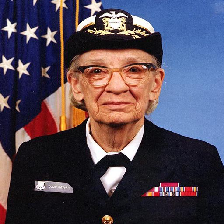

In [8]:
grace_hopper

In [9]:
grace_hopper = np.array(grace_hopper) / 255.0
grace_hopper.shape

(224, 224, 3)

Add a batch dimension and pass it to the model.

In [10]:
result = classifier.predict(grace_hopper[np.newaxis, ...])
result.shape

(1, 1001)

The result is a 1001 element vector of logits, rating the probability of each class for the image.

So the top class ID can be found with `argmax`.

In [11]:
predicted_class = np.argmax(result[0], axis=-1)
predicted_class

653

**Decode the predictions**

In [12]:
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt', 'https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())

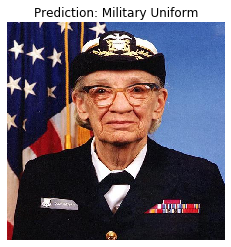

In [13]:
plt.imshow(grace_hopper)
plt.axis('off')
predicted_class_name = imagenet_labels[predicted_class]
plt.title('Prediction: {}'.format(predicted_class_name.title()));

#### Simple transfer learning

Download image data.

In [14]:
data_root = tf.keras.utils.get_file('flower_photos', 'https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz', untar=True)

Load and rescale images.

In [15]:
image_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

In [16]:
image_data = image_gen.flow_from_directory(str(data_root), target_size=IMAGE_SHAPE)

Found 3670 images belonging to 5 classes.


In [17]:
for image_batch, label_batch in image_data:
    print('Image batch shape: {}'.format(image_batch.shape))
    print('Label batch shape: {}'.format(label_batch.shape))
    break

Image batch shape: (32, 224, 224, 3)
Label batch shape: (32, 5)


Run the classifier on the image batch.

In [18]:
result_batch = classifier.predict(image_batch)
result_batch.shape

(32, 1001)

In [19]:
predicted_class_names = imagenet_labels[np.argmax(result_batch, axis=-1)]
predicted_class_names

array(['pot', 'vase', 'mask', 'bee', 'artichoke', 'daisy', 'daisy',
       'cardoon', 'daisy', 'sarong', 'buckeye', 'daisy', 'daisy',
       'rapeseed', 'daisy', 'rapeseed', 'sea urchin', 'paper towel',
       'picket fence', 'daisy', 'daisy', 'daisy', 'picket fence', 'daisy',
       'daisy', 'daisy', 'volcano', 'fly', 'mailbox', 'daisy',
       'cauliflower', 'picket fence'], dtype='<U30')

Check the predictions.

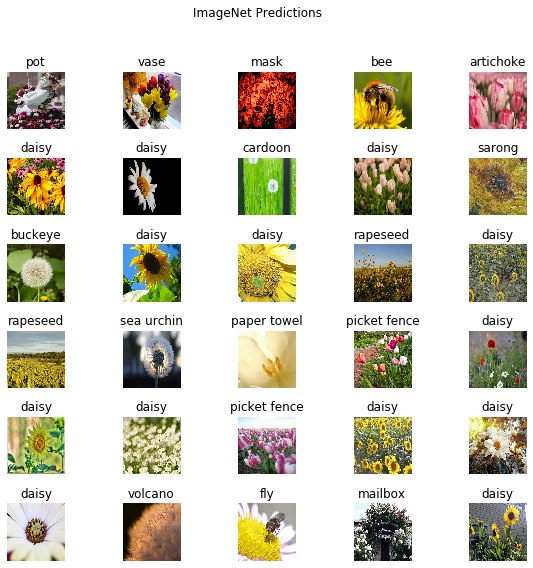

In [20]:
plt.figure(figsize=(10, 9))
plt.subplots_adjust(hspace=0.5)
for i in range(30):
    plt.subplot(6, 5, i+1)
    plt.imshow(image_batch[i])
    plt.title(predicted_class_names[i])
    plt.axis('off')
plt.suptitle('ImageNet Predictions');

As can be seen, the results are far from being correct, but are reasonable considering that these are not the classes the model was trained for.

#### Download the headless model

In [21]:
feature_extractor_url = 'https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2'

Create the feature vector layer.

In [22]:
feature_extractor_layer = hub.KerasLayer(feature_extractor_url, input_shape=(224, 224, 3))

In [23]:
feature_batch = feature_extractor_layer(image_batch)
feature_batch.shape

TensorShape([Dimension(32), Dimension(1280)])

Freeze the variables in the feature extractor layer, so that the training only modifies the new classifier layer.

In [24]:
feature_extractor_layer.trainable = False

**Attache a classification head.**

In [25]:
model = tf.keras.Sequential([
    feature_extractor_layer,
    layers.Dense(image_data.num_classes, activation='softmax')
])

In [26]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 5)                 6405      
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


In [27]:
predictions = model(image_batch)
predictions.shape

TensorShape([Dimension(32), Dimension(5)])

**Compile and Train the model.**

In [28]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
             loss='categorical_crossentropy',
             metrics=['acc'])

In [29]:
# To keep log of loss and accuracy of each batch idividually
class CollectBatchStats(tf.keras.callbacks.Callback):
    def __init__(self):
        self.batch_losses = []
        self.batch_acc = []
        
    def on_train_batch_end(self, batch, logs=None):
        self.batch_losses.append(logs['loss'])
        self.batch_acc.append(logs['acc'])
        self.model.reset_metrics()

In [30]:
steps_per_epoch = np.ceil(image_data.samples/image_data.batch_size)

In [31]:
batch_stats_callback = CollectBatchStats()

In [32]:
history = model.fit(image_data, epochs=2, steps_per_epoch=steps_per_epoch, callbacks=[batch_stats_callback])

Epoch 1/2
115/115 [==============================] - 325s 3s/step - loss: 0.6155 - acc: 0.7500
Epoch 2/2
115/115 [==============================] - 453s 4s/step - loss: 0.3322 - acc: 0.7500


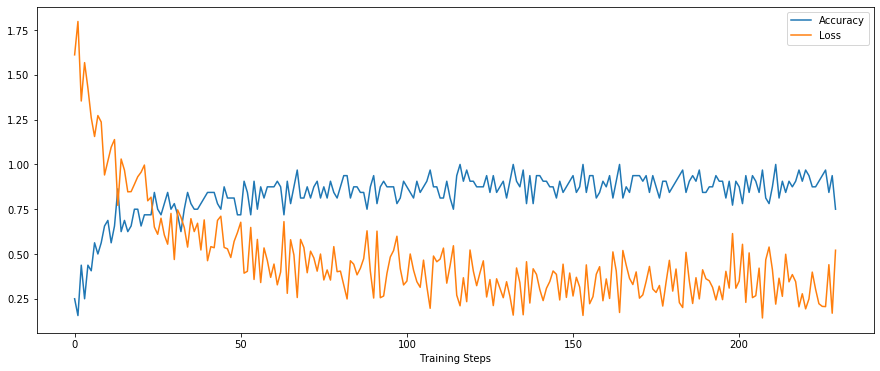

In [33]:
plt.figure(figsize=(15, 6))

plt.plot(batch_stats_callback.batch_acc, label='Accuracy')
plt.plot(batch_stats_callback.batch_losses, label='Loss')
plt.legend()

plt.xlabel('Training Steps')
plt.show()

**Check the predictions.**

In [34]:
class_names = sorted(image_data.class_indices.items(), key=lambda pair: pair[1])
class_names = np.array([key.title() for key, value in class_names])
class_names

array(['Daisy', 'Dandelion', 'Roses', 'Sunflowers', 'Tulips'],
      dtype='<U10')

Run the image batch through the model and convert the indices to class names.

In [35]:
predicted_batch = model.predict(image_batch)
predicted_id = np.argmax(predicted_batch, axis=-1)
predicted_label_batch = class_names[predicted_id]

Plot the results.

In [36]:
label_id = np.argmax(label_batch, axis=-1)

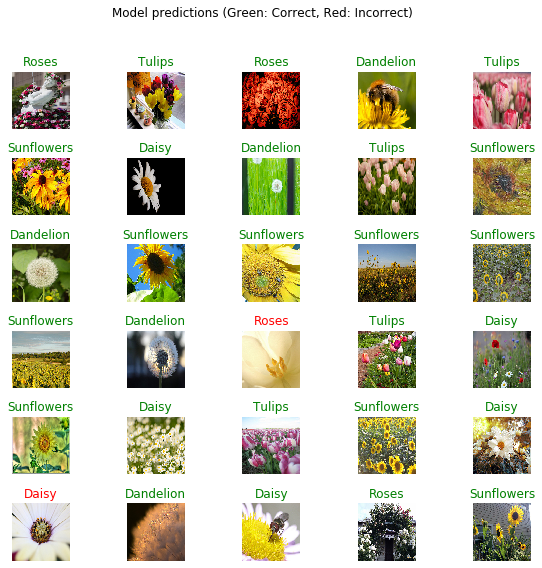

In [37]:
plt.figure(figsize=(10, 9))
plt.subplots_adjust(hspace=0.5)

for i in range(30):
    plt.subplot(6, 5, i+1)
    plt.imshow(image_batch[i])
    color = 'g' if predicted_id[i] == label_id[i] else 'r'
    plt.title(predicted_label_batch[i].title(), color=color)
    plt.axis('off')
    
plt.suptitle('Model predictions (Green: Correct, Red: Incorrect)');

#### Export model

In [38]:
model.save('./saved_models/model.h5')

Let's confirm that we can reload it, and it still gives the same results.

In [39]:
reloaded = tf.keras.models.load_model('./saved_models/model.h5', custom_objects={'KerasLayer':hub.KerasLayer})

In [40]:
result_batch = model.predict(image_batch)
reloaded_result_batch = reloaded.predict(image_batch)

In [41]:
abs(reloaded_result_batch - result_batch).max()

0.0